In [1]:
# Load libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for custom legends
import seaborn as sns

In [2]:
# Load data
demo = pd.read_csv('./data/BD_N4_ACTUALIZADO.csv')
demo.N4 = demo.N4.apply(lambda x : str(x).zfill(4) )
demo = demo[demo.Cen==1]
portugal_mun = gpd.read_file('data/desenvolvimento_sustentavel_mun.geojson')
portugal_mun = portugal_mun.drop(columns=['Sub-Índice Ambiental Dinâmico', 'Sub-Índice Económico Dinâmico',
       'Sub-Índice Social Dinâmico', 'Sub-Índice Institucional Dinâmico',
       'Índice Agregado Dinâmico', 'Sub-Índice Ambiental Estático',
       'Sub-Índice Económico Estático', 'Sub-Índice Social Estático',
       'Sub-Índice Institucional Estático', 'Índice Agregado Estático',
       'Financiamento Total (QREN + PT2020)',
       'Financiamento Total (QREN + PT2020) -  Per Capita', 'Eficiência CCR'])
portugal_mun = portugal_mun[~portugal_mun.NUTSI_COD.isin([2,3])]


In [3]:
demo.Ano.unique()

array([2010, 2015, 2020, 2025, 2030, 2035, 2040])

In [4]:
# Check what scenario are the pessimist
demo[(demo.Ano==2030) & (demo.N4=='1601') & (demo.Cen == 1)].PopAbertM.sum()

10860

In [5]:
demo[(demo.Ano==2030) & (demo.N4=='1601') & (demo.Cen == 2)].PopAbertM.sum()

0

In [6]:
demo[(demo.Ano==2030) & (demo.N4=='1601') & (demo.Cen == 3)].PopAbertM.sum()

0

In [7]:
# check missing data
demo[demo.N4 =='0503']
demo[demo.N4=='1001'] # Alcobaça

,N3,N4,Ano,GE,PopAbertH,PopAbertM,PopFechH,PopFechM,Cen


In [8]:
# Create the base dataframe for demographic projections
sum_df = pd.DataFrame()  # Initialize an empty DataFrame
desired_years = [2020, 2030, 2040]

for year in desired_years:
    filtered_demo = demo[demo['Ano'].isin([year])]
    year_sum_df = filtered_demo.groupby('N4').sum()
    year_sum_df.drop(columns=['N3', 'GE', 'Ano', 'Cen'], inplace=True)
    year_sum_df['Total_Aberta_{}'.format(year)] = year_sum_df.PopAbertH + year_sum_df.PopAbertM
    year_sum_df['Total_Fechada_{}'.format(year)] = year_sum_df.PopFechH + year_sum_df.PopFechM
    year_sum_df.rename(columns={'PopAbertH': 'PopAbertH_{}'.format(year), 'PopAbertM': 'PopAbertM_{}'.format(year)}, inplace=True)
    year_sum_df.rename(columns={'PopFechH': 'PopFechH_{}'.format(year), 'PopFechM': 'PopFechM_{}'.format(year)}, inplace=True)

    if sum_df.empty:
        sum_df = year_sum_df
    else:
        sum_df = sum_df.merge(year_sum_df, on='N4', how='outer')

# Calculate ratios based on the desired years
base_year = desired_years[0]
for year in desired_years[1:]:
    ratio_column = 'ratio_{}'.format(year)
    sum_df[ratio_column] = ((sum_df['Total_Aberta_{}'.format(year)] / sum_df['Total_Aberta_{}'.format(base_year)]) - 1) * 100
    sum_df[ratio_column] = sum_df[ratio_column].round(2)



In [9]:
# Merge with refered data
portugal_mun_partial = portugal_mun.merge(sum_df, right_on=[sum_df.index], left_on=[portugal_mun.DTMN], how='left')

In [10]:
# Get all NaN values

list_of_missing_DTMN_data = list(portugal_mun_partial[portugal_mun_partial.ratio_2040.isna()].DTMN.unique())


# Define the file paths
file_paths = [
    'data/POP_FECHADAS_N5/BD_N5 111-117_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 118-164_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 165-193_ACTUALIZADO.csv',
    'data/POP_FECHADAS_N5/BD_N5 171-150_ACTUALIZADO.csv'
]

# Read the CSV files and store them in a list
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    dfs.append(df)

# Concatenate the dataframes vertically
combined_df = pd.concat(dfs, ignore_index=True)

# Format the 'N4' column as a string with 4 characters, filled with 0
combined_df['N4'] = combined_df['N4'].astype(str).str.zfill(4)


/tmp/ipykernel_129089/3462751041.py:17: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [11]:
# 1. Filter the combined N5 data for the desired years and missing N4 municipalities
filtered_combined_df = combined_df[combined_df['N4'].isin(list_of_missing_DTMN_data) & combined_df['Ano'].isin(desired_years)]

# 1. Identify the unique columns to detect duplicates
unique_columns = ['N4', 'N5', 'Ano', 'Cen', 'GE']

# Drop duplicates based on the unique columns, keeping the first occurrence
filtered_combined_df = filtered_combined_df.drop_duplicates(subset=unique_columns, keep='first')
filtered_combined_df = filtered_combined_df[filtered_combined_df.Cen==1]


# 2. Aggregate the data at the N4 level for each year in the desired_years list
aggregated_dfs = []
for year in desired_years:
    # Filter by the desired year
    year_filtered_combined_df = filtered_combined_df[filtered_combined_df['Ano'] == year]
    
    # Group by N4 and sum only the required columns
    year_aggregated_df = year_filtered_combined_df.groupby('N4')[['PopAbertH', 'PopAbertM', 'PopFechH', 'PopFechM']].sum()
    
    # Calculate the total columns
    year_aggregated_df['Total_Aberta_{}'.format(year)] = year_aggregated_df.PopAbertH + year_aggregated_df.PopAbertM
    year_aggregated_df['Total_Fechada_{}'.format(year)] = year_aggregated_df.PopFechH + year_aggregated_df.PopFechM
    
    # Rename the columns to include the year
    year_aggregated_df.rename(columns={
        'PopAbertH': 'PopAbertH_{}'.format(year),
        'PopAbertM': 'PopAbertM_{}'.format(year),
        'PopFechH': 'PopFechH_{}'.format(year),
        'PopFechM': 'PopFechM_{}'.format(year)
    }, inplace=True)
    
    # Append the aggregated DataFrame to the list
    aggregated_dfs.append(year_aggregated_df)

# Concatenate the aggregated dataframes horizontally
missing_N4_data = pd.concat(aggregated_dfs, axis=1)

# 3. Merge the aggregated N5 data with the existing N4 data to update the missing municipalities
sum_df.update(missing_N4_data)

# 4. Concatenate sum_df and Missing_N4_data
final_df = pd.concat([sum_df, missing_N4_data], axis=0)
final_df = final_df.loc[~final_df.index.duplicated(keep='first')]

# Recalculate the ratios based on the updated data
base_year = desired_years[0]
for year in desired_years[1:]:
    ratio_column = 'ratio_{}'.format(year)
    final_df[ratio_column] = ((final_df['Total_Aberta_{}'.format(year)] / final_df['Total_Aberta_{}'.format(base_year)]) - 1) * 100
    final_df[ratio_column] = final_df[ratio_column].round(2)



In [12]:
missing_N4_data.loc['1001']

PopAbertH_2020        22287
PopAbertM_2020        24038
PopFechH_2020         22638
PopFechM_2020         24389
Total_Aberta_2020     46325
Total_Fechada_2020    47027
PopAbertH_2030        20721
PopAbertM_2030        22464
PopFechH_2030         21033
PopFechM_2030         22748
Total_Aberta_2030     43185
Total_Fechada_2030    43781
PopAbertH_2040        19155
PopAbertM_2040        20731
PopFechH_2040         19436
PopFechM_2040         21000
Total_Aberta_2040     39886
Total_Fechada_2040    40436
Name: 1001, dtype: int64

In [13]:
final_df.loc['1001']

PopAbertH_2020        22287.00
PopAbertM_2020        24038.00
PopFechH_2020         22638.00
PopFechM_2020         24389.00
Total_Aberta_2020     46325.00
Total_Fechada_2020    47027.00
PopAbertH_2030        20721.00
PopAbertM_2030        22464.00
PopFechH_2030         21033.00
PopFechM_2030         22748.00
Total_Aberta_2030     43185.00
Total_Fechada_2030    43781.00
PopAbertH_2040        19155.00
PopAbertM_2040        20731.00
PopFechH_2040         19436.00
PopFechM_2040         21000.00
Total_Aberta_2040     39886.00
Total_Fechada_2040    40436.00
ratio_2030               -6.78
ratio_2040              -13.90
Name: 1001, dtype: float64

In [14]:
portugal_mun = portugal_mun.merge(final_df, right_on=[final_df.index], left_on=[portugal_mun.DTMN], how='left')

In [15]:
portugal_mun[portugal_mun.ratio_2040.isna()]

,key_0,DTMN,NUTSI_DSG,NUTSI_COD,NUTSII_DSG,NUTSII_COD,NUTSIII_DSG,NUTSIII_COD,DISTRITO_ILHA_DSG,CONCELHO_DSG,...,Total_Aberta_2030,Total_Fechada_2030,PopAbertH_2040,PopAbertM_2040,PopFechH_2040,PopFechM_2040,Total_Aberta_2040,Total_Fechada_2040,ratio_2030,ratio_2040


In [16]:
portugal_mun.to_file('data/demographic_2020_2030_2040_mun.geojson', driver='GeoJSON')
# portugal_mun.to_file('data/demographic_2020_2040_mun.geojson', driver='GeoJSON')

In [17]:
# a pergunta a que queria responder é a seguinte:
# quantas pessoas terá (a mais ou a menos) cada uma destas partes do país, em 2040?

# Load density map data
high_density = gpd.read_file('data/polignos_alta_baixa_densidade/alta_densidade_corrigido.shp')
low_density = gpd.read_file('data/polignos_alta_baixa_densidade/baixa_densidade_poligno.shp')

In [18]:
# Convert to WGS84
high_density.to_crs(epsg=4326, inplace=True)
low_density.to_crs(epsg=4326, inplace=True)

In [19]:
portugal_mun.columns

Index(['key_0', 'DTMN', 'NUTSI_DSG', 'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD',
       'NUTSIII_DSG', 'NUTSIII_COD', 'DISTRITO_ILHA_DSG', 'CONCELHO_DSG',
       'geometry', 'PopAbertH_2020', 'PopAbertM_2020', 'PopFechH_2020',
       'PopFechM_2020', 'Total_Aberta_2020', 'Total_Fechada_2020',
       'PopAbertH_2030', 'PopAbertM_2030', 'PopFechH_2030', 'PopFechM_2030',
       'Total_Aberta_2030', 'Total_Fechada_2030', 'PopAbertH_2040',
       'PopAbertM_2040', 'PopFechH_2040', 'PopFechM_2040', 'Total_Aberta_2040',
       'Total_Fechada_2040', 'ratio_2030', 'ratio_2040'],
      dtype='object')

<Axes: >

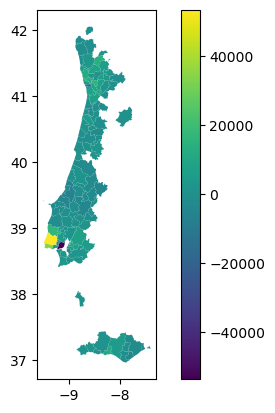

In [20]:
# For HiGH DENSITY region
  
desired_merge_data = portugal_mun[['DTMN', 'Total_Fechada_2020', 'Total_Fechada_2040']]

high_density = high_density.merge(desired_merge_data, right_on=['DTMN'], left_on=['DICO'], how='left')
high_density['surplus_2040'] = high_density['Total_Fechada_2040'] - high_density['Total_Fechada_2020']
high_density.plot(column='surplus_2040', legend=True)

In [21]:
# For LOW DENSITY region
 
joined_gdf = portugal_mun[portugal_mun.intersects(low_density.unary_union)]
joined_gdf['surplus_2040'] = joined_gdf['Total_Fechada_2040'] - joined_gdf['Total_Fechada_2020']
low_density = joined_gdf


/home/fillipe/anaconda3/envs/python_kepler_jupyter/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

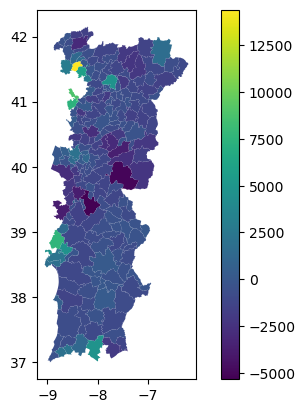

In [22]:
joined_gdf.plot('surplus_2040', legend=True)

In [23]:
portugal_mun_boundaries = portugal_mun.dissolve(by='NUTSI_COD')
high_density['join'] = 1
high_density_boundaries = high_density.dissolve(by='join')
joined_gdf_boundaries = joined_gdf.dissolve(by='NUTSI_COD')

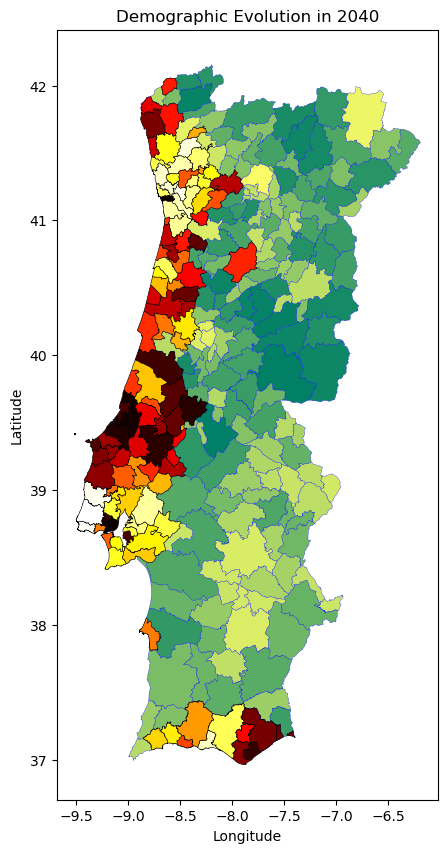

In [24]:


# Set up the plot
fig, ax = plt.subplots(figsize=(14, 10))


# Plot low-density municipalities
low_density.plot(ax=ax, column='surplus_2040', categorical=True,
                 cmap='summer', linewidth=0.2, edgecolor='blue')

# Plot high-density municipalities
high_density.plot(ax=ax, column='surplus_2040', categorical=True,
                  cmap='hot', linewidth=0.4, edgecolor='black')

# Customize the plot
ax.set_title('Demographic Evolution in 2040')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


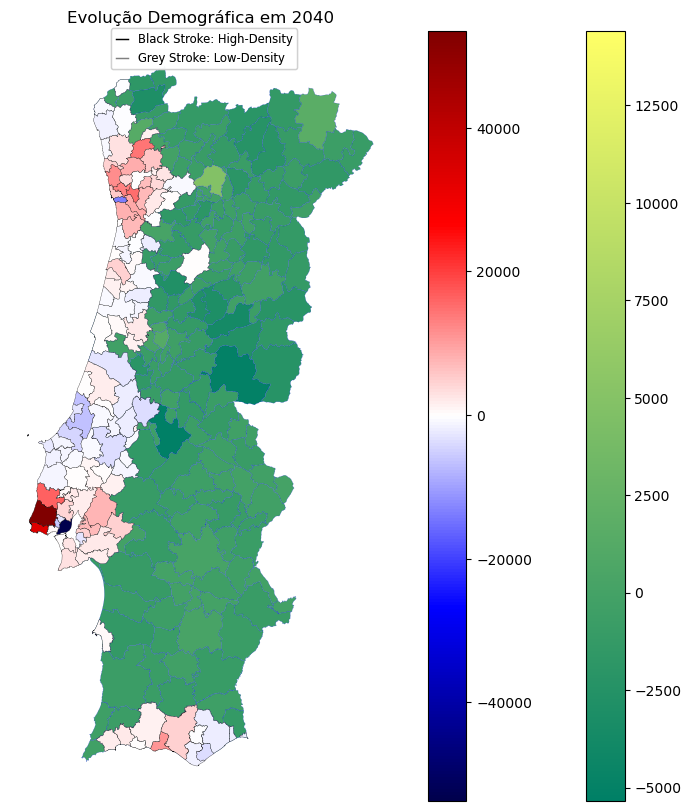

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming you have two geodataframes: high_density and low_density

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot low-density municipalities
low_density.plot(ax=ax, column='surplus_2040', cmap='summer', linewidth=0.1, edgecolor='blue', legend=True)

# Plot high-density municipalities
high_density.plot(ax=ax, column='surplus_2040', cmap='seismic', linewidth=0.2, edgecolor='black', legend=True)

# Customize the plot
ax.set_title('Evolução Demográfica em 2040')

# Remove frame lines showing map coordinates
ax.set_frame_on(False)
ax.axis('off')


# Create a custom legend for stroke municipalities
custom_legend = ax.legend(handles=[Line2D([], [], color='black', linewidth=1),
                                   Line2D([], [], color='grey', linewidth=1)],
                          labels=['Black Stroke: High-Density', 'Grey Stroke: Low-Density'], loc='upper left', fontsize='small', handlelength=1.1)

# Adjust the position of the legend
custom_legend.set_bbox_to_anchor((0.25, 1.011))
# Add the custom legends to the plot
ax.add_artist(custom_legend)



# Show the plot
plt.show()



In [26]:
# low_density.to_file('data/low_density.geojson', driver='GeoJSON')
# high_density.to_file('data/high_density.geojson', driver='GeoJSON')

In [27]:
# Join data with the density maps

portugal_mun.columns

Index(['key_0', 'DTMN', 'NUTSI_DSG', 'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD',
       'NUTSIII_DSG', 'NUTSIII_COD', 'DISTRITO_ILHA_DSG', 'CONCELHO_DSG',
       'geometry', 'PopAbertH_2020', 'PopAbertM_2020', 'PopFechH_2020',
       'PopFechM_2020', 'Total_Aberta_2020', 'Total_Fechada_2020',
       'PopAbertH_2030', 'PopAbertM_2030', 'PopFechH_2030', 'PopFechM_2030',
       'Total_Aberta_2030', 'Total_Fechada_2030', 'PopAbertH_2040',
       'PopAbertM_2040', 'PopFechH_2040', 'PopFechM_2040', 'Total_Aberta_2040',
       'Total_Fechada_2040', 'ratio_2030', 'ratio_2040'],
      dtype='object')

In [28]:
low_density.columns

Index(['key_0', 'DTMN', 'NUTSI_DSG', 'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD',
       'NUTSIII_DSG', 'NUTSIII_COD', 'DISTRITO_ILHA_DSG', 'CONCELHO_DSG',
       'geometry', 'PopAbertH_2020', 'PopAbertM_2020', 'PopFechH_2020',
       'PopFechM_2020', 'Total_Aberta_2020', 'Total_Fechada_2020',
       'PopAbertH_2030', 'PopAbertM_2030', 'PopFechH_2030', 'PopFechM_2030',
       'Total_Aberta_2030', 'Total_Fechada_2030', 'PopAbertH_2040',
       'PopAbertM_2040', 'PopFechH_2040', 'PopFechM_2040', 'Total_Aberta_2040',
       'Total_Fechada_2040', 'ratio_2030', 'ratio_2040', 'surplus_2040'],
      dtype='object')

In [29]:
high_density.columns

Index(['DICO', 'Concelho', 'Distrito', 'N_Freguesi', 'NUTSIII', 'NUTSII',
       'NUTSI', 'Alt_Max', 'Alt_Min', 'Area_ha', 'Perim_km', 'geometry',
       'DTMN', 'Total_Fechada_2020', 'Total_Fechada_2040', 'surplus_2040',
       'join'],
      dtype='object')

In [30]:
import numpy as np
portugal_mun['density'] = np.where(portugal_mun.index.isin(low_density.index), 'low', 'high')
portugal_mun['surplus_2040'] = portugal_mun['Total_Fechada_2040'] - portugal_mun['Total_Fechada_2020']


In [31]:
portugal_mun.columns


Index(['key_0', 'DTMN', 'NUTSI_DSG', 'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD',
       'NUTSIII_DSG', 'NUTSIII_COD', 'DISTRITO_ILHA_DSG', 'CONCELHO_DSG',
       'geometry', 'PopAbertH_2020', 'PopAbertM_2020', 'PopFechH_2020',
       'PopFechM_2020', 'Total_Aberta_2020', 'Total_Fechada_2020',
       'PopAbertH_2030', 'PopAbertM_2030', 'PopFechH_2030', 'PopFechM_2030',
       'Total_Aberta_2030', 'Total_Fechada_2030', 'PopAbertH_2040',
       'PopAbertM_2040', 'PopFechH_2040', 'PopFechM_2040', 'Total_Aberta_2040',
       'Total_Fechada_2040', 'ratio_2030', 'ratio_2040', 'density',
       'surplus_2040'],
      dtype='object')

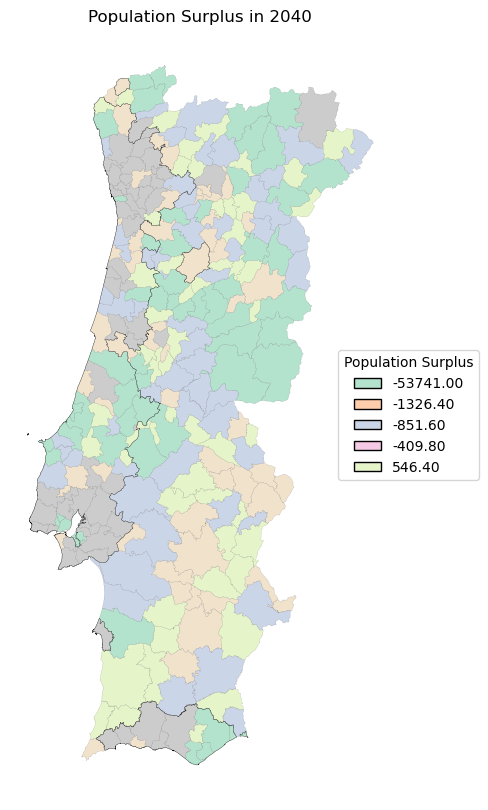

In [32]:

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the choropleth map with 5 quantiles
portugal_mun.plot(ax=ax, column='surplus_2040', cmap='Pastel2', linewidth=0.05, edgecolor='black', legend=True, scheme='quantiles', k=5)

# Plot the high-density boundaries without filling
high_density_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.2)

# Customize the plot
ax.set_title('Population Surplus in 2040')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Remove frame lines showing map coordinates
ax.set_frame_on(False)
ax.axis('off')

# Adjust plot layout
plt.subplots_adjust(right=0.85)

# Get the quantile values
quantile_values = portugal_mun['surplus_2040'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).tolist()
quantile_labels = ['{:.2f}'.format(q) for q in quantile_values]

# Create custom legend
colors = sns.color_palette('Pastel2', n_colors=5)
patches = [mpatches.Patch(facecolor=color, edgecolor='black', label=label) for color, label in zip(colors, quantile_labels)]

# Position the legend on the right side
ax.legend(handles=patches, title='Population Surplus', loc='center right', bbox_to_anchor=(1.25, 0.5))

# Show the plot
plt.show()


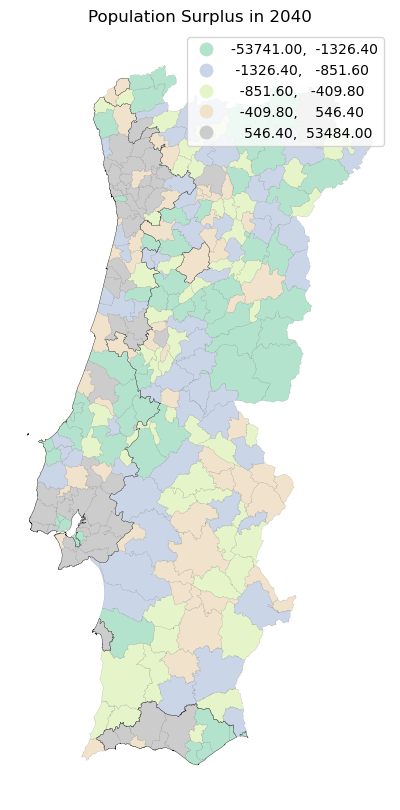

In [33]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the choropleth map with 5 quantiles
portugal_mun.plot(ax=ax, column='surplus_2040', cmap='Pastel2', linewidth=0.05, edgecolor='black', legend=True, scheme='quantiles', k=5)

# Plot the high-density boundaries without filling
high_density_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.2)

# Customize the plot
ax.set_title('Population Surplus in 2040')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Remove frame lines showing map coordinates
ax.set_frame_on(False)
ax.axis('off')

# Show the plot
plt.show()

In [34]:
portugal_mun.surplus_2040.describe()

count      278.000000
mean        85.428058
std       5855.501355
min     -53741.000000
25%      -1189.500000
50%       -652.000000
75%         43.250000
max      53484.000000
Name: surplus_2040, dtype: float64

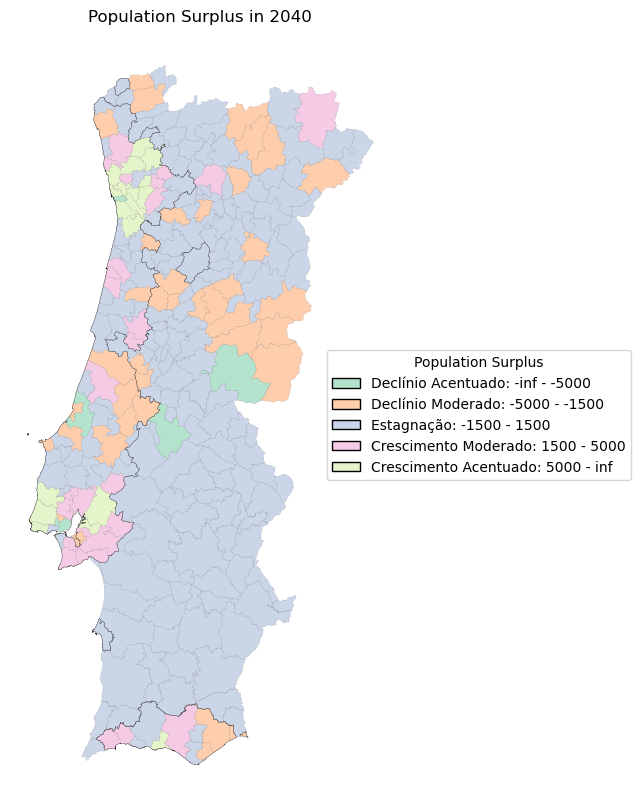

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors

# Assuming you have the portugal_mun GeoDataFrame and high_density_boundaries GeoDataFrame

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define the classification and labels
classification = [-float('inf'), -5000, -1500, 1500, 5000, float('inf')]
labels = ['Declínio Acentuado', 'Declínio Moderado', 'Estagnação', 'Crescimento Moderado', 'Crescimento Acentuado']

# Classify the data based on 'surplus_2040'
portugal_mun['surplus_class'] = pd.cut(portugal_mun['surplus_2040'], bins=classification, labels=labels, right=False)

# Create custom colormap based on 'Pastel2'
pastel2_colors = sns.color_palette('Pastel2', len(labels))
pastel2_cmap = colors.ListedColormap(list(pastel2_colors))

# Plot the choropleth map with the classified data and custom colormap
portugal_mun.plot(ax=ax, column='surplus_class', cmap=pastel2_cmap, linewidth=0.05, edgecolor='black', legend=True)

# Plot the high-density boundaries without filling
high_density_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.2)

# Customize the plot
ax.set_title('Population Surplus in 2040')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Remove frame lines showing map coordinates
ax.set_frame_on(False)
ax.axis('off')

# Adjust plot layout
plt.subplots_adjust(right=0.85)

# Create custom legend with range labels and corresponding colors
legend_patches = []
for i in range(len(classification) - 1):
    if i == 2:  # Modify the 'Estagnação' class range
        estagnacao_range = f'{classification[i]} - {classification[i+1]}'
        estagnacao_label = f'{labels[i]}: {estagnacao_range}'
        legend_patch = mpatches.Patch(facecolor=pastel2_colors[i], edgecolor='black', label=estagnacao_label)
    else:
        legend_patch = mpatches.Patch(facecolor=pastel2_colors[i], edgecolor='black', label=f'{labels[i]}: {classification[i]} - {classification[i+1]}')
    legend_patches.append(legend_patch)

# Position the legend on the right side
plt.subplots_adjust(right=0.85)
ax.legend(handles=legend_patches, title='Population Surplus', loc='center right', bbox_to_anchor=(1.65, 0.5))

# Show the plot
plt.show()


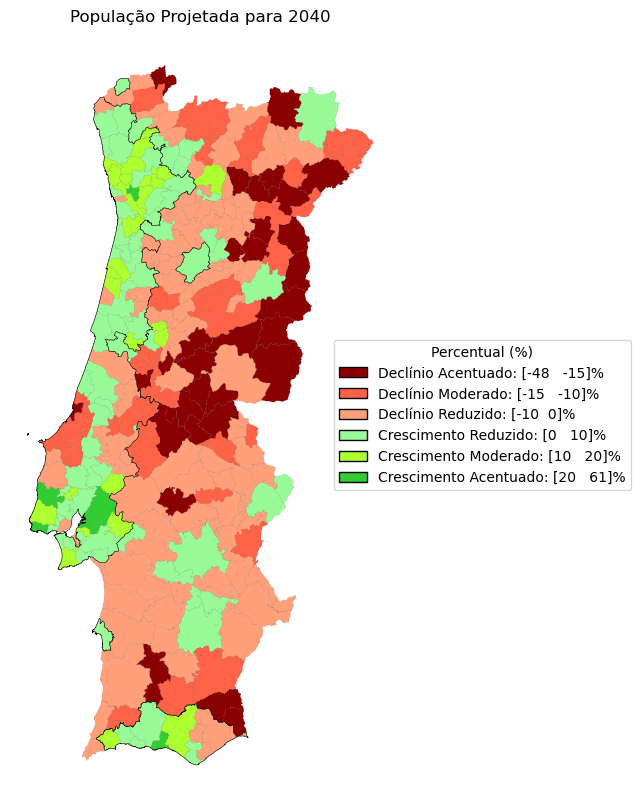

In [36]:

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Define the classification and labels for 'ratio_2040'
classification = [-48, -15, -10, 0, 10, 20, 61]
labels = ['Declínio Acentuado', 'Declínio Moderado', "Declínio Reduzido",  'Crescimento Reduzido', 'Crescimento Moderado', 'Crescimento Acentuado']

# Classify the data based on 'ratio_2040'
portugal_mun['ratio_class'] = pd.cut(portugal_mun['ratio_2040'], bins=classification, labels=labels, right=False)

# Define the custom colors for each label
custom_colors = ['#8B0000', '#FF6347', '#FFA07A', '#98FB98', '#ADFF2F','#32CD32']


custom_cmap = colors.ListedColormap(custom_colors)

# Plot the choropleth map with the classified data and custom colormap
portugal_mun.plot(ax=ax, column='ratio_class', cmap=custom_cmap, linewidth=0.05, edgecolor='black', legend=True)

# Plot the high-density boundaries without filling
high_density_boundaries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.4)

# Customize the plot
ax.set_title('População Projetada para 2040')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Remove frame lines showing map coordinates
ax.set_frame_on(False)
ax.axis('off')

# Adjust plot layout
plt.subplots_adjust(right=0.85)

# Create custom legend with range labels and corresponding colors
legend_patches = []
for i in range(len(classification) - 1):
    if i == 2:  # Modify the 'Estagnação' class range
        estagnacao_range = f'[{classification[i]}  {classification[i+1]}]'
        estagnacao_label = f'{labels[i]}: {estagnacao_range}%'
        legend_patch = mpatches.Patch(facecolor=custom_colors[i], edgecolor='black', label=estagnacao_label)
    else:
        legend_patch = mpatches.Patch(facecolor=custom_colors[i], edgecolor='black', label=f'{labels[i]}: [{classification[i]}   {classification[i+1]}]%')
    legend_patches.append(legend_patch)

# Position the legend on the right side
plt.subplots_adjust(right=0.85)
ax.legend(handles=legend_patches, title='Percentual (%)', loc='center right', bbox_to_anchor=(1.65, 0.5))

# Show the plot
plt.show()


In [37]:
portugal_mun.ratio_2040.describe()

count    278.000000
mean      -2.736691
std       10.943514
min      -34.420000
25%      -10.337500
50%       -3.490000
75%        4.452500
max       44.570000
Name: ratio_2040, dtype: float64

In [38]:
portugal_mun.to_csv('data/demographic_2020_2030_2040_mun.csv', index=False)